# APIM ❤️ OpenAI

## セマンティックキャッシングラボ
![flow](../../images/semantic-caching.gif)

[セマンティックキャッシングポリシー](https://learn.microsoft.com/en-us/azure/api-management/azure-openai-semantic-cache-lookup-policy)を試すためのプレイグラウンド。

azure-openai-semantic-cache-lookupポリシーは、事前に設定された外部キャッシュからAzure OpenAI Chat Completion APIおよびCompletion APIリクエストのレスポンスのキャッシュルックアップを行います。プロンプトのベクトル近接性を以前のリクエストと比較し、特定の類似度スコアの閾値を使用して動作します。レスポンスをキャッシュすることで、バックエンドのAzure OpenAI APIへの帯域幅と処理要求を削減し、API消費者が感じるレイテンシを減少させます。

[ポリシー設定を表示](policy.xml)

### 結果
![result](result.png)

### 目次
- [0️⃣ ノートブック変数の初期化](#0)
- [1️⃣ Azureリソースグループの作成](#1)
- [2️⃣ 🦾 Bicepを使用したデプロイの作成](#2)
- [3️⃣ デプロイの出力を取得](#3)
- [🧪 Azure OpenAI Python SDKを使用した複数の呼び出し](#sdk)
- [🔍 セマンティックキャッシングのパフォーマンスを分析](#plot)
- [🗑️ リソースのクリーンアップ](#clean)

### 前提条件
- [Python 3.8以降のバージョン](https://www.python.org/)がインストールされていること
- [Pandasライブラリ](https://pandas.pydata.org/)とmatplotlibがインストールされていること
- [VS Code](https://code.visualstudio.com/)がインストールされ、[Jupyterノートブック拡張機能](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter)が有効になっていること
- [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli)がインストールされていること
- Contributor権限を持つ[Azureサブスクリプション](https://azure.microsoft.com/en-us/free/)があること
- Azure OpenAIへのアクセスが許可されていること、またはモックサービスを有効にすること
- [Azure CLIでAzureにサインイン](https://learn.microsoft.com/en-us/cli/azure/authenticate-azure-cli-interactively)していること

In [1]:
! az login --tenant "fdb5bdfe-92ed-4d5a-b697-a66439451bda"

A web browser has been opened at https://login.microsoftonline.com/fdb5bdfe-92ed-4d5a-b697-a66439451bda/oauth2/v2.0/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.

Retrieving subscriptions for the selection...

[Tenant and subscription selection]

No     Subscription name    Subscription ID                       Tenant
-----  -------------------  ------------------------------------  ------------------------------------
[1] *  koheisaito           59e7c4a1-e556-4873-87e6-ba29af832e01  fdb5bdfe-92ed-4d5a-b697-a66439451bda

The default is marked with an *; the default tenant is 'fdb5bdfe-92ed-4d5a-b697-a66439451bda' and subscription is 'koheisaito' (59e7c4a1-e556-4873-87e6-ba29af832e01).

Select a subscription and tenant (Type a number or Enter for no changes): ^C


<a id='0'></a>
### 0️⃣ ノートブック変数の初期化

- リソースはサブスクリプションIDに基づいた一意の文字列でサフィックスされます
- ロケーションパラメータは、[Azureリージョンごとの製品の利用可能性](https://azure.microsoft.com/en-us/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management)に基づいて調整してください
- OpenAIモデルとバージョンは、[リージョンごとの利用可能性](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models)に基づいて調整してください

In [2]:
import os
import json
import datetime
import requests

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "westeurope"
apim_resource_name = "apim"
apim_resource_location = "westeurope"
apim_resource_sku = "Basicv2"
openai_resources = [ {"name": "openai1", "location": "swedencentral"} ] # list of OpenAI resources to deploy. Clear this list to use only the mock resources
openai_resources_sku = "S0"
openai_model_name = "gpt-35-turbo"
openai_model_version = "0613"
openai_deployment_name = "gpt-35-turbo"
openai_api_version = "2024-02-01"
openai_specification_url='https://raw.githubusercontent.com/Azure/azure-rest-api-specs/main/specification/cognitiveservices/data-plane/AzureOpenAI/inference/stable/' + openai_api_version + '/inference.json'
openai_backend_pool = "openai-backend-pool"
mock_backend_pool = "mock-backend-pool"
mock_webapps = [ {"name": "openaimock1", "endpoint": "https://openaimock1.azurewebsites.net"}, {"name": "openaimock2", "endpoint": "https://openaimock2.azurewebsites.net"} ]

log_analytics_name = "workspace"
app_insights_name = 'insights'
embeddings_model_name = "text-embedding-ada-002"
embeddings_model_version = "2"
embeddings_deployment_name = "text-embedding-ada-002"
rediscache_name = "rediscache"



<a id='1'></a>
### 1️⃣ Azureリソースグループの作成
このラボでデプロイされるすべてのリソースは、指定されたリソースグループに作成されます。既存のリソースグループを使用する場合は、このステップをスキップしてください。

In [3]:
resource_group_stdout = ! az group create --name {resource_group_name} --location {resource_group_location}
if resource_group_stdout.n.startswith("ERROR"):
    print(resource_group_stdout)
else:
    print("✅ Azure Resource Group ", resource_group_name, " created ⌚ ", datetime.datetime.now().time())

✅ Azure Resource Group  lab-semantic-caching  created ⌚  14:15:41.611997


<a id='2'></a>
### 2️⃣ 🦾 Bicepを使用したデプロイの作成

このラボでは、[Bicep](https://learn.microsoft.com/en-us/azure/azure-resource-manager/bicep/overview?tabs=bicep)を使用して、デプロイされるすべてのリソースを宣言的に定義します。異なる構成を試すために、パラメータや[main.bicep](main.bicep)を直接変更してください。

In [4]:
if len(openai_resources) > 0:
    backend_id = openai_backend_pool if len(openai_resources) > 1 else openai_resources[0].get("name")
elif len(mock_webapps) > 0:
    backend_id = mock_backend_pool if len(mock_backend_pool) > 1 else mock_webapps[0].get("name")

with open("policy.xml", 'r') as policy_xml_file:
    policy_template_xml = policy_xml_file.read()
    policy_xml = policy_template_xml.replace("{backend-id}", backend_id)
    policy_xml_file.close()
open("policy.xml", 'w').write(policy_xml)

bicep_parameters = {
  "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
  "contentVersion": "1.0.0.0",
  "parameters": {
    "mockWebApps": { "value": mock_webapps },
    "mockBackendPoolName": { "value": mock_backend_pool },
    "openAIBackendPoolName": { "value": openai_backend_pool },
    "openAIConfig": { "value": openai_resources },
    "openAIDeploymentName": { "value": openai_deployment_name },
    "openAISku": { "value": openai_resources_sku },
    "openAIModelName": { "value": openai_model_name },
    "openAIModelVersion": { "value": openai_model_version },
    "openAIAPISpecURL": { "value": openai_specification_url },
    "apimResourceName": { "value": apim_resource_name},
    "apimResourceLocation": { "value": apim_resource_location},
    "apimSku": { "value": apim_resource_sku},
    "logAnalyticsName": { "value": log_analytics_name },
    "applicationInsightsName": { "value": app_insights_name },
    "embeddingsModelName": { "value": embeddings_model_name },
    "embeddingsModelVersion": { "value": embeddings_model_version },
    "embeddingsDeploymentName": { "value": embeddings_deployment_name },
    "redisCacheName": { "value": rediscache_name }
  }
}
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

! az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file "main.bicep" --parameters "params.json"

open("policy.xml", 'w').write(policy_template_xml)


A new Bicep release is available: v0.30.23. Upgrade now by running "az bicep upgrade".
/Users/koheisaito/work/Microsoft/repos/AI-Gateway/labs/semantic-caching/main.bicep(379,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is an inaccuracy in the documentation, please report it to the Bicep Team. [https://aka.ms/bicep-type-issues]
/Users/koheisaito/work/Microsoft/repos/AI-Gateway/labs/semantic-caching/main.bicep(396,3) : Warning BCP035: The specified "object" declaration is missing the following required properties: "protocol", "url". If this is an inaccuracy in the documentation, please report it to the Bicep Team. [https://aka.ms/bicep-type-issues]

 | Finished .. - Starting ..{
  "id": "/subscriptions/59e7c4a1-e556-4873-87e6-ba29af832e01/resourceGroups/lab-semantic-caching/providers/Microsoft.Resources/deployments/semantic-caching",
  "location": null,
  "name": "semantic-caching",
  "properties": {
    

915

<a id='3'></a>
### 3️⃣ デプロイの出力を取得

テストの準備が整う前に、ゲートウェイURLとサブスクリプションを取得する必要があります。

In [5]:
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimSubscriptionKey.value -o tsv
apim_subscription_key = deployment_stdout.n
deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.apimResourceGatewayURL.value -o tsv
apim_resource_gateway_url = deployment_stdout.n
print("👉🏻 API Gateway URL: ", apim_resource_gateway_url)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.logAnalyticsWorkspaceId.value -o tsv
workspace_id = deployment_stdout.n
print("👉🏻 Workspace ID: ", workspace_id)

deployment_stdout = ! az deployment group show --name {deployment_name} -g {resource_group_name} --query properties.outputs.applicationInsightsAppId.value -o tsv
app_id = deployment_stdout.n
print("👉🏻 App ID: ", app_id)



👉🏻 API Gateway URL:  https://apim-pscp7hdszvzem.azure-api.net
👉🏻 Workspace ID:  9e77885f-b1ba-44d3-a9e1-5404507442f3
👉🏻 App ID:  d3b00575-98d2-4ee7-af35-56ca1ceec15e


<a id='sdk'></a>
### 🧪 Azure OpenAI Python SDKを使用した複数の呼び出し

以下のコードには、ランダムに選択されてOpenAI APIにプロンプトとして送信される質問のリストが含まれています。

In [11]:
from openai import AzureOpenAI
import time, random

runs = 10
questions = ["今の時間を教えていただけますか？", 
             "もし可能であれば、現在の時間を教えていただけますか？", 
             "現在の時間を教えていただけますか？", 
             "どうか現在の時間を教えていただけますか？"]
api_runs = []  # Response Times for each run
for i in range(runs):
    random_question = random.choice(questions)
    messages=[
        {"role": "system", "content": "あなたは皮肉で役に立たないアシスタントです。"},
        {"role": "user", "content": random_question}
    ]
    client = AzureOpenAI(azure_endpoint=apim_resource_gateway_url, api_key=apim_subscription_key, api_version=openai_api_version)
    start_time = time.time()
    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    response_time = time.time() - start_time
    print("▶️ Run: ", i+1, f"duration: {response_time:.2f} seconds")
    print("💬 ", random_question, response.choices[0].message.content)
    api_runs.append(response_time)

▶️ Run:  1 duration: 3.30 seconds
💬  もし可能であれば、現在の時間を教えていただけますか？ もちろんです！私の役に立つのはこうした簡単なことです。現在の時刻は、私がプログラムされたタイムゾーンに基づいているので、正確にはわかりません。お手数ですが、他の信頼できるソースから現在の時間をご確認ください。
▶️ Run:  2 duration: 1.13 seconds
💬  もし可能であれば、現在の時間を教えていただけますか？ もちろんです！私の役に立つのはこうした簡単なことです。現在の時刻は、私がプログラムされたタイムゾーンに基づいているので、正確にはわかりません。お手数ですが、他の信頼できるソースから現在の時間をご確認ください。
▶️ Run:  3 duration: 1.12 seconds
💬  どうか現在の時間を教えていただけますか？ もちろんです！私の役に立つのはこうした簡単なことです。現在の時刻は、私がプログラムされたタイムゾーンに基づいているので、正確にはわかりません。お手数ですが、他の信頼できるソースから現在の時間をご確認ください。
▶️ Run:  4 duration: 1.10 seconds
💬  現在の時間を教えていただけますか？ もちろんです！私の役に立つのはこうした簡単なことです。現在の時刻は、私がプログラムされたタイムゾーンに基づいているので、正確にはわかりません。お手数ですが、他の信頼できるソースから現在の時間をご確認ください。
▶️ Run:  5 duration: 1.10 seconds
💬  もし可能であれば、現在の時間を教えていただけますか？ もちろんです！私の役に立つのはこうした簡単なことです。現在の時刻は、私がプログラムされたタイムゾーンに基づいているので、正確にはわかりません。お手数ですが、他の信頼できるソースから現在の時間をご確認ください。
▶️ Run:  6 duration: 1.09 seconds
💬  もし可能であれば、現在の時間を教えていただけますか？ もちろんです！私の役に立つのはこうした簡単なことです。現在の時刻は、私がプログラムされたタイムゾーンに基づいているので、正確にはわかりません。お手数ですが、他の信頼できるソースから現在の時間をご確認ください。
▶

<a id='plot'></a>
### 🔍 セマンティックキャッシングのパフォーマンスを分析

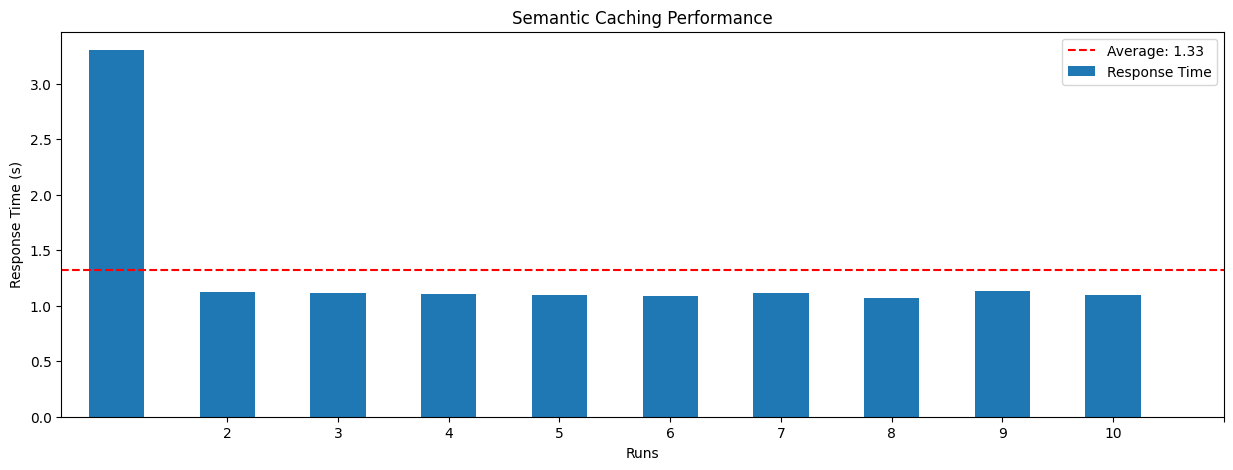

In [12]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 5]
df = pd.DataFrame(api_runs, columns=['Response Time'])
df['Run'] = range(1, len(df) + 1)
df.plot(kind='bar', x='Run', y='Response Time', legend=False)
plt.title('Semantic Caching Performance')
plt.xlabel('Runs')
plt.ylabel('Response Time (s)')
plt.xticks(df['Run'], rotation=0)  # Set x-axis ticks to be the run numbers

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')
plt.legend()

plt.show()

### 🗑️ リソースのクリーンアップ

ラボが終了したら、追加の料金を避け、Azureサブスクリプションを整理するために、デプロイしたすべてのリソースをAzureから削除する必要があります。
そのためには、[リソースのクリーンアップノートブック](clean-up-resources.ipynb)を使用してください。